<a href="https://colab.research.google.com/github/ysmnpksy/Final-Project/blob/main/LSTMGRULayers_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>LSTM & GRU Layers</h1>
By Yasmin Paksoy

# Table of Contents 
  * [Preparing the Data](#section1)
  * [Build Functions](#build)
  * [Model 1: First LSTM Model](#model2)
  * [Tuning: Dropout](#dropout)
    * [Model 2: Rate 20%](#model3)
    * [Model 3: Rate 40%](#model4)
    * [Model 4: Rate 50%](#model5)
  * [Tuning: Number of Layers](#layers)
    * [Failed Model: 2 Layers](#model6)
  * [Model 5: GRU](#model7)
  * [Tuning Learning Rate](#Learning-Rate)
    * [Model 6: 0.003](#model8)
    * [Model 7: 0.006](#model9)
    * [Model 8: 0.004](#model10)
    * [Model 9: 0.01](#model11)
  * [Training Final Model](#FinalModel)

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yasminpaksoy","key":"9092d77ded0787db0dc92dec0c6c058c"}'}

In [ ]:
# making kaggle directory 
! mkdir ~/.kaggle

# copying api login info into directory 
! cp kaggle.json ~/.kaggle/

# allocating required permissions 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rmisra/imdb-spoiler-dataset

# unzipping dataset 
! unzip imdb-spoiler-dataset.zip

 94% 313M/331M [00:03<00:00, 98.0MB/s]
100% 331M/331M [00:03<00:00, 108MB/s] 
Archive:  imdb-spoiler-dataset.zip
  inflating: IMDB_movie_details.json  
  inflating: IMDB_reviews.json       


In [ ]:
# importing pandas to read the JSON files
import pandas as pd 

# information regarding reviews file
all_reviews = pd.read_json('../content/IMDB_reviews.json', lines=True)

print('Total number of reviews:', all_reviews['review_date'].count())
print('Total number of reviews that contain spoilers:', all_reviews['is_spoiler'].sum())
print('User reviews shape:', all_reviews.shape)
print()

print('First 5 user reviews:')
all_reviews.head()

Total number of reviews: 573913
Total number of reviews that contain spoilers: 150924
User reviews shape: (573913, 7)

First 5 user reviews:


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


# Preparing the Data <a class="anchor" id="preparing"></a>
--------------------------------
As shown in previous code cells, the reviews database contains 573,913 records, 150,924 of them which contain spoilers. 

In the code cell below, I am converting the reviews and their labels into lists from the JSON file they were loaded in with. During this process, I am adding all reviews that contain spoilers to this list but only 150,924 reviews that don't. This leaves me with a fully balances dataset, which can be seen in the calculations below. 

In [ ]:
import json

labels = [] 
texts = []

with open('IMDB_reviews.json', 'r') as json_file:
  for jsonObj in json_file:
    data = json.loads(jsonObj)
    if data['is_spoiler'] == True:
       labels.append(1)
    else:
       labels.append(0)
    texts.append(data['review_text'])

Next, I am preparing the data. For this data to be inputted into a machine-learning model, it needs to be formatted into tensors which are small in value and normalized if heterogeneous. Heterogeneous data refers to the data being in different ranges, and while deep neural networks can adapt to this, it makes learning more difficult [1]. 

The data is currently not in tensors, so I will be tokenizing the text data using one-hot encoding. To do this I am using the `Tokenizer` module from Keras. I have cut the reviews of after a maximum of 500 words and am only considering the most frequent 15000 words in the dataset. 

After tokenizing, I have vectorized the data using the `pad_sequences` module from Keras, which converts the list of tokenized data, integers, into 2D tensors, which can then be fed into the neural network. I have also vectorized the list of labels by converting it to a list of floating point numbers.

This data is now ready to be inputted into a machine-learning model. 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 500 # cuts reviews off after 500 words 
max_words = 15000 # considers only the top 15,000 words in the dataset 

# tokenizing texts 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# vectorizing texts
data = pad_sequences(sequences, maxlen=maxlen)

# vectorizing labels 
labels = np.asarray(labels).astype('float32')

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 379856 unique tokens.
Shape of data tensor: (573913, 500)
Shape of label tensor: (573913,)


Lastly, to prepare the data, I am splitting it into training and testing sets. This way I will be testing the model on unseen data only, ensuring information leaking does not affect the final results. I will be training on 201,848 data points and testing on 100,00.

I am first shuffling the data, since the JSON file lists all reviews including spoilers first, then splitting it.

In [ ]:
# suffling data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# setting number of training and testing samples
training_samples = 523913
testing_samples = 50000

# splitting into training and testing sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + testing_samples]
y_test = labels[training_samples: training_samples + testing_samples]

In [ ]:
print('Training data shape:',x_train.shape)
print('Training labels shape:', y_train.shape)

print('Test data shape:',x_test.shape)
print('Test labels shape:',y_test.shape)

Training data shape: (523913, 500)
Training labels shape: (523913,)
Test data shape: (50000, 500)
Test labels shape: (50000,)


Here I am further splitting the training set into partial training and validation. This ensures that the data used to validate will not be the same as that used to train, helping avoid overfitting issues. I will be training on 151,848 samples and validating on 50,000. 

In [ ]:
# setting number of training and validation samples
partial_training_samples = 473913
validation_samples = 50000

# splitting into training and validation sets
x_partial_train_unbal = data[:partial_training_samples]
y_partial_train_unbal = labels[:partial_training_samples]
x_val = data[partial_training_samples: partial_training_samples + validation_samples]
y_val = labels[partial_training_samples: partial_training_samples + validation_samples]

In [ ]:
print('Partial training data shape:',x_partial_train_unbal.shape)
print('Partial training labels shape:', y_partial_train_unbal.shape)

print('Validation data shape:',x_val.shape)
print('Validation labels shape:',y_val.shape)

Partial training data shape: (473913, 500)
Partial training labels shape: (473913,)
Validation data shape: (50000, 500)
Validation labels shape: (50000,)


In [ ]:
spoilers = 0;
nonSpoilers = 0;

for i in y_partial_train_unbal: 
  if i == 1: 
    spoilers += 1 
  else: 
    nonSpoilers += 1

print("Total number of reviews: " + str(len(labels)))
print("Total nummber with spoilers: " + str(spoilers))
print("Total number without spoilers " + str(nonSpoilers))

Total number of reviews: 573913
Total nummber with spoilers: 124707
Total number without spoilers 349206


In [ ]:
x_partial_train = [] 
y_partial_train = []
sum = 0

for data in range(len(y_partial_train_unbal)):
  if y_partial_train_unbal[data] == 1:
    y_partial_train.append(1)
    x_partial_train.append(x_partial_train_unbal[data])
  else:
    if sum < spoilers:
      sum += 1
      y_partial_train.append(0)
      x_partial_train.append(x_partial_train_unbal[data])

In [ ]:
spoilers = 0;
nonSpoilers = 0;

for i in y_partial_train: 
  if i == 1: 
    spoilers += 1 
  else: 
    nonSpoilers += 1

print("Total number of reviews: " + str(len(x_partial_train)))
print("Total nummber with spoilers: " + str(spoilers))
print("Total number without spoilers " + str(nonSpoilers))

Total number of reviews: 249414
Total nummber with spoilers: 124707
Total number without spoilers 124707


In [ ]:
x_val = np.array(x_val)
y_val = np.array(y_val)
x_partial_train = np.array(x_partial_train) 
y_partial_train = np.array(y_partial_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Build Functions <a class="anchor" id="build"></a>
---------------------
I have included all the functions I will use below.

The code functions I have included are: 
* Build baseline model. 
* Build scaled up model. 
* Build model with dropout and recurrent dropout. 
* Plot loss function. 
* Plot final loss function. 
* Plot accuracy function. 
* Plot final accuracy function. 
* Train function. 
* Train final model function. 
* Evaluate function. 



In [ ]:
# Importing all necessary libraries
import tensorflow as tf
import keras
import matplotlib.pyplot as plt


from gc import callbacks
from keras import models, layers
from tensorflow.keras import optimizers
from keras.layers import Embedding, Flatten, LSTM

In [ ]:
def build_small():
  model = models.Sequential()
  
  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8, input_length=maxlen))
  
  # flattens the 3D tensor output to a 2D tensor
  model.add(Flatten())
  
  # training single dense layer for classfication  
  model.add(layers.Dense(32, activation = 'relu'))
  # output layer 
  model.add(layers.Dense(1, activation = 'sigmoid'))
  
  model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
  model.build()
  model.summary()
  return model

In [ ]:
def build_scaled_up():
  model = models.Sequential()

  # Embedding layers 
  # network will learn 32-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  model.add(LSTM(32))
  # output layer
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_dropout(drop, rec_drop):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop
                 ))
  
  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_layers(drop, rec_drop, layer):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500), 
                 return_sequences=True))
  
  if layer==2:
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop))
    
  if layer==3:
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop,
                   return_sequences=True))
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop))

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_GRU(drop, rec_drop):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(layers.GRU(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500)))

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_learning_rate(drop, rec_drop, lr):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(layers.GRU(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500))
  )

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer = optimizers.RMSprop(learning_rate = lr),
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_optimizer(drop, rec_drop, optimizer):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(layers.GRU(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500))
  )

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  if optimizer == 'Adam':
    model.compile(optimizer = optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['acc'])
  else:
    model.compile(optimizer = optimizers.Nadam(),
                  loss='binary_crossentropy',
                  metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def plot_outputs():

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
    )]

In [ ]:
def train(model, epoch):
  return model.fit(x_partial_train, y_partial_train,
                   epochs = epoch,
                   batch_size = 128,
                   callbacks = callbacks_list,
                   validation_data = (x_val, y_val))

In [ ]:
def train_final_model(model, epoch):
  return model.fit(x_train, y_train, epochs = epoch, batch_size = 128)

In [ ]:
def evaluate():
  model.evaluate(x_test, y_test)

# Model 1: First LSTM Model<a class="anchor" id="model2"></a>
-------------------------

In [ ]:
model = build_scaled_up()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
829/829 [==============================] - 268s 323ms/step - loss: 0.5280 - acc: 0.7450 - val_loss: 0.5379 - val_acc: 0.7245
Epoch 2/50
829/829 [==============================] - 268s 323ms/step - loss: 0.5205 - acc: 0.7499 - val_loss: 0.5754 - val_acc: 0.7232
Epoch 3/50
829/829 [==============================] - 270s 326ms/step - loss: 0.5135 - acc: 0.7546 - val_loss: 0.5252 - val_acc: 0.7548
Epoch 4/50
829/829 [==============================] - 269s 325ms/step - loss: 0.5059 - acc: 0.7604 - val_loss: 0.5719 - val_acc: 0.7209
Epoch 5/50
829/829 [==============================] - 269s 325ms/step - loss: 0.4979 - acc: 0.7656 - val_loss: 0.6241 - val_acc: 0.6595
Epoch 6/50
829/829 [==============================] - 274s 330ms/step - loss: 0.4896 - acc: 0.7710 - val_loss: 0.6312 - val_acc: 0.6860
Epoch 7/50
829/829 [==============================] - 269s 325ms/step - loss: 0.4802 - acc: 0.7749 - val_loss: 0.6020 - val_acc: 0.7381
Epoch 8/50
829/829 [============================

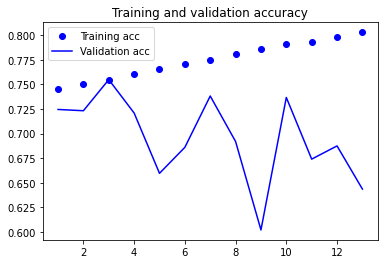

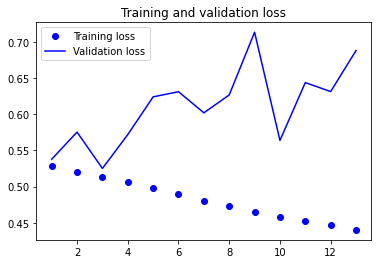

In [ ]:
plot_outputs()

# Tuning: Dropout <a class="anchor" id="dropout"></a>
------------

## Model 2: Rate 20% <a class="anchor" id="model3"></a>
-----------------------

In [ ]:
model = build_dropout(0.2, 0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                5248      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1942/1942 [==============================] - 1310s 673ms/step - loss: 0.6218 - acc: 0.6538 - val_loss: 0.6264 - val_acc: 0.6615
Epoch 2/50
1942/1942 [==============================] - 1302s 671ms/step - loss: 0.5833 - acc: 0.6996 - val_loss: 0.5696 - val_acc: 0.7245
Epoch 3/50
1942/1942 [==============================] - 1310s 675ms/step - loss: 0.5706 - acc: 0.7077 - val_loss: 0.5113 - val_acc: 0.7547
Epoch 4/50
1942/1942 [==============================] - 1304s 672ms/step - loss: 0.5616 - acc: 0.7127 - val_loss: 0.5999 - val_acc: 0.7083
Epoch 5/50
1942/1942 [==============================] - 1305s 672ms/step - loss: 0.5559 - acc: 0.7186 - val_loss: 0.5307 - val_acc: 0.7437
Epoch 6/50
1942/1942 [==============================] - 1311s 675ms/step - loss: 0.5500 - acc: 0.7212 - val_loss: 0.5565 - val_acc: 0.7347
Epoch 7/50
1942/1942 [==============================] - 1326s 683ms/step - loss: 0.5472 - acc: 0.7235 - val_loss: 0.5660 - val_acc: 0.7148
Epoch 8/50
1942/1942 [=====

Below I have included graphs showing the training and validation accuracy and loss of this model:


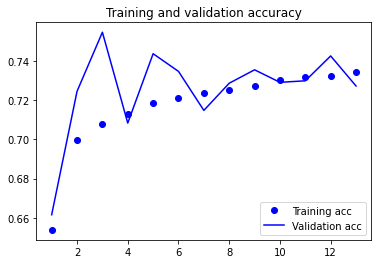

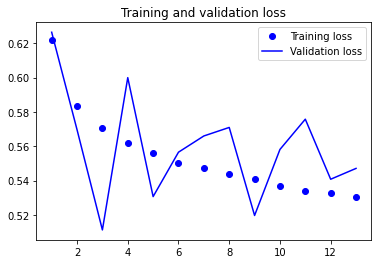

In [ ]:
plot_outputs()

## Model 3: Rate 40% <a class="anchor" id="model4"></a>
-----------------------

In [ ]:
model = build_dropout(0.4, 0.4)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_6 (LSTM)               (None, 32)                5248      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1942/1942 [==============================] - 1342s 683ms/step - loss: 0.6294 - acc: 0.6497 - val_loss: 0.5619 - val_acc: 0.7132
Epoch 2/50
1942/1942 [==============================] - 1312s 675ms/step - loss: 0.5946 - acc: 0.6921 - val_loss: 0.5704 - val_acc: 0.6950
Epoch 3/50
1942/1942 [==============================] - 1307s 673ms/step - loss: 0.5764 - acc: 0.7034 - val_loss: 0.5920 - val_acc: 0.7116
Epoch 4/50
1942/1942 [==============================] - 1304s 671ms/step - loss: 0.5665 - acc: 0.7075 - val_loss: 0.5707 - val_acc: 0.6959
Epoch 5/50
1942/1942 [==============================] - 1313s 676ms/step - loss: 0.5580 - acc: 0.7133 - val_loss: 0.5408 - val_acc: 0.7064
Epoch 6/50
1942/1942 [==============================] - 1313s 676ms/step - loss: 0.5510 - acc: 0.7180 - val_loss: 0.5398 - val_acc: 0.7381
Epoch 7/50
1942/1942 [==============================] - 1314s 677ms/step - loss: 0.5470 - acc: 0.7190 - val_loss: 0.5284 - val_acc: 0.7536
Epoch 8/50
1942/1942 [=====

Graphs showing the training and validation loss and accuracy can be found below:

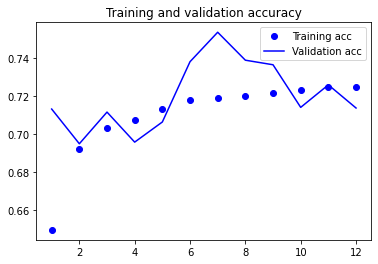

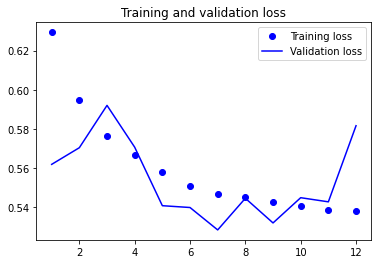

In [ ]:
plot_outputs()

## Model 4: Rate 30% <a class="anchor" id="model5"></a>
-----------------------

In [ ]:
model = build_dropout(0.3, 0.3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_7 (LSTM)               (None, 32)                5248      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1942/1942 [==============================] - 1286s 661ms/step - loss: 0.6260 - acc: 0.6522 - val_loss: 0.5645 - val_acc: 0.7099
Epoch 2/50
1942/1942 [==============================] - 1284s 661ms/step - loss: 0.5835 - acc: 0.6960 - val_loss: 0.5431 - val_acc: 0.7353
Epoch 3/50
1942/1942 [==============================] - 1289s 664ms/step - loss: 0.5700 - acc: 0.7066 - val_loss: 0.5368 - val_acc: 0.7452
Epoch 4/50
1942/1942 [==============================] - 1287s 663ms/step - loss: 0.5614 - acc: 0.7128 - val_loss: 0.5710 - val_acc: 0.7151
Epoch 5/50
1942/1942 [==============================] - 1286s 662ms/step - loss: 0.5556 - acc: 0.7158 - val_loss: 0.6110 - val_acc: 0.6875
Epoch 6/50
1942/1942 [==============================] - 1303s 671ms/step - loss: 0.5491 - acc: 0.7211 - val_loss: 0.5331 - val_acc: 0.7419
Epoch 7/50
1942/1942 [==============================] - 1309s 674ms/step - loss: 0.5445 - acc: 0.7236 - val_loss: 0.6129 - val_acc: 0.6581
Epoch 8/50
1942/1942 [=====

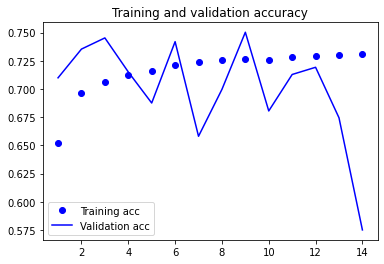

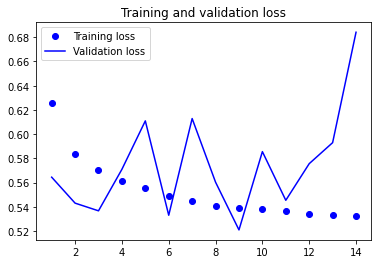

In [ ]:
plot_outputs()

# Tuning: Number of Layers <a class="anchor" id="layers"></a>
----------------------------
Next, I will be changing the architecture by adding layers. Adding layers will increase the capacity of the network, making it more likely to learn important patterns that can allow it to make more accurate predictions. 

## Failed Model: 2 Layers <a class="anchor" id="model6"></a>
--------------------
For the next model, I will be increasing the number of LSTM layers to 2. The model definition can be seen below. 

In [ ]:
model = build_layers(0.4, 0.4, 2)

In [ ]:
history = train(model, 50)

# Model 5: First GRU Model <a class="anchor" id="model7"></a>
-----------------

In [ ]:
model = build_GRU(0.2, 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1942/1942 [==============================] - 1143s 587ms/step - loss: 0.6357 - acc: 0.6277 - val_loss: 0.5548 - val_acc: 0.7095
Epoch 2/50
1942/1942 [==============================] - 1136s 585ms/step - loss: 0.5721 - acc: 0.7024 - val_loss: 0.5629 - val_acc: 0.7116
Epoch 3/50
1942/1942 [==============================] - 1135s 585ms/step - loss: 0.5557 - acc: 0.7149 - val_loss: 0.5379 - val_acc: 0.7363
Epoch 4/50
1942/1942 [==============================] - 1133s 583ms/step - loss: 0.5466 - acc: 0.7209 - val_loss: 0.5986 - val_acc: 0.6803
Epoch 5/50
1942/1942 [==============================] - 1132s 583ms/step - loss: 0.5407 - acc: 0.7251 - val_loss: 0.5395 - val_acc: 0.7317
Epoch 6/50
1942/1942 [==============================] - 1132s 583ms/step - loss: 0.5359 - acc: 0.7276 - val_loss: 0.5575 - val_acc: 0.7131
Epoch 7/50
1942/1942 [==============================] - 1130s 582ms/step - loss: 0.5319 - acc: 0.7305 - val_loss: 0.5687 - val_acc: 0.7074
Epoch 8/50
1942/1942 [=====

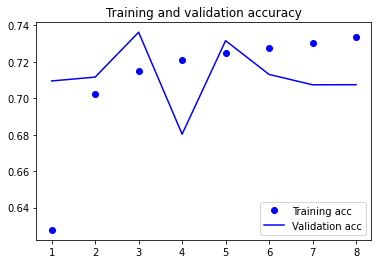

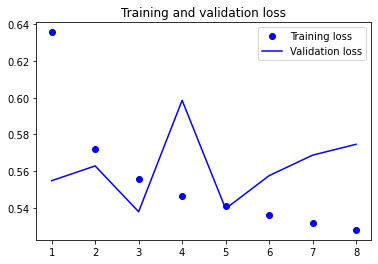

In [ ]:
plot_outputs()

# Tuning: Learning Rate <a class="anchor" id="Learning-Rate"></a>
----------------------------

## Model 6: 0.003 <a class="anchor" id="model8"></a>
-----------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.003)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_1 (GRU)                 (None, 32)                4032      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 1109s 568ms/step - loss: 0.6352 - acc: 0.6300 - val_loss: 0.5705 - val_acc: 0.7058
Epoch 2/50
1948/1948 [==============================] - 1120s 575ms/step - loss: 0.5608 - acc: 0.7068 - val_loss: 0.5278 - val_acc: 0.7462
Epoch 3/50
1948/1948 [==============================] - 1124s 577ms/step - loss: 0.5463 - acc: 0.7189 - val_loss: 0.5673 - val_acc: 0.7017
Epoch 4/50
1948/1948 [==============================] - 1122s 576ms/step - loss: 0.5374 - acc: 0.7265 - val_loss: 0.5211 - val_acc: 0.7422
Epoch 5/50
1948/1948 [==============================] - 1126s 578ms/step - loss: 0.5301 - acc: 0.7322 - val_loss: 0.5402 - val_acc: 0.7212
Epoch 6/50
1948/1948 [==============================] - 1129s 580ms/step - loss: 0.5251 - acc: 0.7360 - val_loss: 0.5166 - val_acc: 0.7359
Epoch 7/50
1948/1948 [==============================] - 1128s 579ms/step - loss: 0.5200 - acc: 0.7396 - val_loss: 0.5051 - val_acc: 0.7537
Epoch 8/50
1948/1948 [=====

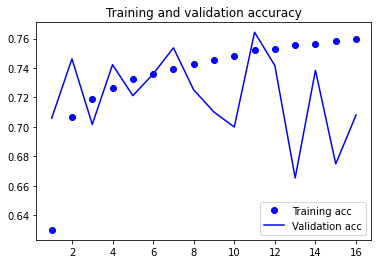

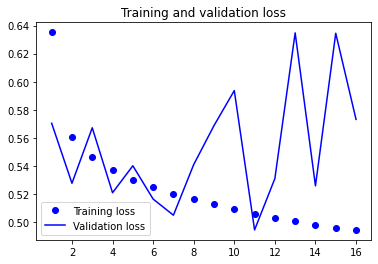

In [ ]:
plot_outputs()

## Model 7: 0.006 <a class="anchor" id="model9"></a>
--------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.006)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_4 (GRU)                 (None, 32)                4032      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 1146s 587ms/step - loss: 0.6005 - acc: 0.6646 - val_loss: 0.5126 - val_acc: 0.7567
Epoch 2/50
1948/1948 [==============================] - 1143s 587ms/step - loss: 0.5569 - acc: 0.7112 - val_loss: 0.5328 - val_acc: 0.7373
Epoch 3/50
1948/1948 [==============================] - 1145s 588ms/step - loss: 0.5442 - acc: 0.7203 - val_loss: 0.6561 - val_acc: 0.6451
Epoch 4/50
1948/1948 [==============================] - 1147s 589ms/step - loss: 0.5369 - acc: 0.7263 - val_loss: 0.5524 - val_acc: 0.7209
Epoch 5/50
1948/1948 [==============================] - 1148s 589ms/step - loss: 0.5296 - acc: 0.7307 - val_loss: 0.5913 - val_acc: 0.6834
Epoch 6/50
1948/1948 [==============================] - 1146s 589ms/step - loss: 0.5250 - acc: 0.7344 - val_loss: 0.5879 - val_acc: 0.6977


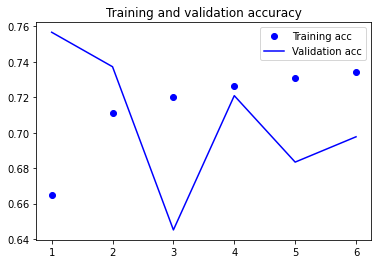

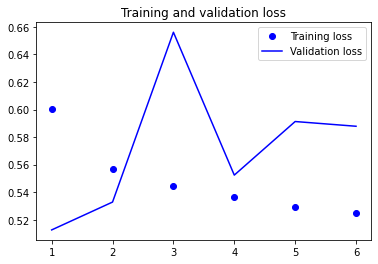

In [ ]:
plot_outputs()

## Model 8: 0.004 <a class="anchor" id="model10"></a>
----------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.004)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_7 (GRU)                 (None, 32)                4032      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 1148s 583ms/step - loss: 0.6089 - acc: 0.6537 - val_loss: 0.5535 - val_acc: 0.7209
Epoch 2/50
1948/1948 [==============================] - 1135s 583ms/step - loss: 0.5570 - acc: 0.7096 - val_loss: 0.5211 - val_acc: 0.7407
Epoch 3/50
1948/1948 [==============================] - 1151s 591ms/step - loss: 0.5446 - acc: 0.7200 - val_loss: 0.5295 - val_acc: 0.7363
Epoch 4/50
1948/1948 [==============================] - 1143s 587ms/step - loss: 0.5363 - acc: 0.7270 - val_loss: 0.4830 - val_acc: 0.7701
Epoch 5/50
1948/1948 [==============================] - 1152s 591ms/step - loss: 0.5291 - acc: 0.7323 - val_loss: 0.5213 - val_acc: 0.7411
Epoch 6/50
1948/1948 [==============================] - 1153s 592ms/step - loss: 0.5230 - acc: 0.7369 - val_loss: 0.6096 - val_acc: 0.6701
Epoch 7/50
1948/1948 [==============================] - 1148s 590ms/step - loss: 0.5183 - acc: 0.7406 - val_loss: 0.5498 - val_acc: 0.7230
Epoch 8/50
1948/1948 [=====

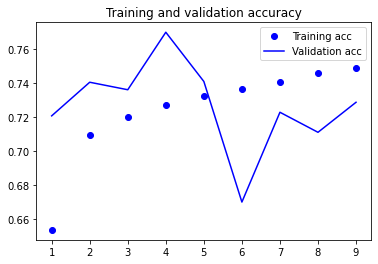

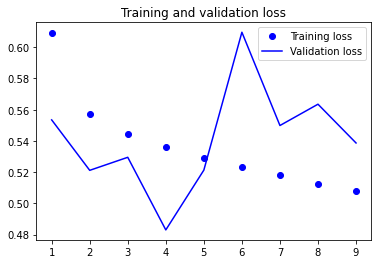

In [ ]:
plot_outputs()

## Model 9: 0.01 <a class="anchor" id="model11"></a>
-----------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.01)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 1133s 580ms/step - loss: 0.5949 - acc: 0.6685 - val_loss: 0.4870 - val_acc: 0.7791
Epoch 2/50
1949/1949 [==============================] - 1111s 570ms/step - loss: 0.5515 - acc: 0.7149 - val_loss: 0.5518 - val_acc: 0.7216
Epoch 3/50
1949/1949 [==============================] - 1124s 577ms/step - loss: 0.5393 - acc: 0.7240 - val_loss: 0.5758 - val_acc: 0.6916
Epoch 4/50
1949/1949 [==============================] - 1124s 577ms/step - loss: 0.5331 - acc: 0.7296 - val_loss: 0.4941 - val_acc: 0.7671
Epoch 5/50
1949/1949 [==============================] - 1141s 585ms/step - loss: 0.5280 - acc: 0.7330 - val_loss: 0.5190 - val_acc: 0.7470
Epoch 6/50
1949/1949 [==============================] - 1125s 577ms/step - loss: 0.5238 - acc: 0.7369 - val_loss: 0.6043 - val_acc: 0.6808


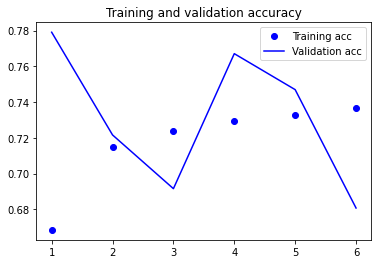

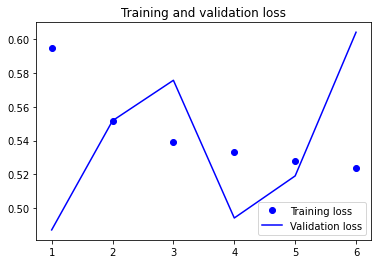

In [ ]:
plot_outputs()

## Model 10: Adam Optimizer
---------------------------

In [ ]:
model = build_optimizer(0.2, 0.2, 'Adam')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_5 (GRU)                 (None, 32)                4032      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 1140s 583ms/step - loss: 0.6223 - acc: 0.6435 - val_loss: 0.5815 - val_acc: 0.6972
Epoch 2/50
1949/1949 [==============================] - 1124s 576ms/step - loss: 0.5580 - acc: 0.7118 - val_loss: 0.5569 - val_acc: 0.7282
Epoch 3/50
1949/1949 [==============================] - 1138s 584ms/step - loss: 0.5420 - acc: 0.7244 - val_loss: 0.5555 - val_acc: 0.7245
Epoch 4/50
1949/1949 [==============================] - 1144s 587ms/step - loss: 0.5313 - acc: 0.7316 - val_loss: 0.5553 - val_acc: 0.7241
Epoch 5/50
1949/1949 [==============================] - 1153s 592ms/step - loss: 0.5221 - acc: 0.7384 - val_loss: 0.5544 - val_acc: 0.7179
Epoch 6/50
1949/1949 [==============================] - 1133s 581ms/step - loss: 0.5135 - acc: 0.7444 - val_loss: 0.5533 - val_acc: 0.7222
Epoch 7/50
1949/1949 [==============================] - 1143s 587ms/step - loss: 0.5039 - acc: 0.7509 - val_loss: 0.5690 - val_acc: 0.7056
Epoch 8/50
1949/1949 [=====

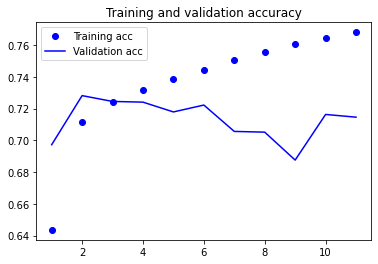

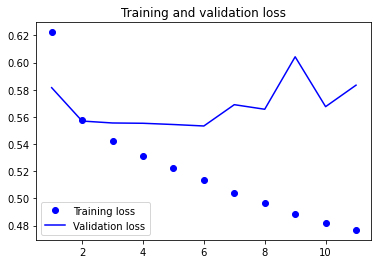

In [ ]:
plot_outputs()

## Model 11: Nadam Optimizer
---------------------------

In [ ]:
model = build_optimizer(0.2, 0.2, 'Nadam')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_6 (GRU)                 (None, 32)                4032      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 1158s 588ms/step - loss: 0.6839 - acc: 0.5448 - val_loss: 0.6024 - val_acc: 0.6625
Epoch 2/50
1949/1949 [==============================] - 1156s 593ms/step - loss: 0.5789 - acc: 0.6915 - val_loss: 0.5598 - val_acc: 0.7110
Epoch 3/50
1949/1949 [==============================] - 1123s 576ms/step - loss: 0.5514 - acc: 0.7154 - val_loss: 0.5776 - val_acc: 0.6992
Epoch 4/50
1949/1949 [==============================] - 1122s 575ms/step - loss: 0.5409 - acc: 0.7231 - val_loss: 0.5667 - val_acc: 0.7108
Epoch 5/50
1949/1949 [==============================] - 1135s 582ms/step - loss: 0.5335 - acc: 0.7299 - val_loss: 0.5420 - val_acc: 0.7272
Epoch 6/50
1949/1949 [==============================] - 1141s 585ms/step - loss: 0.5278 - acc: 0.7331 - val_loss: 0.5544 - val_acc: 0.7186
Epoch 7/50
1949/1949 [==============================] - 1137s 583ms/step - loss: 0.5227 - acc: 0.7377 - val_loss: 0.5877 - val_acc: 0.6957
Epoch 8/50
1949/1949 [=====

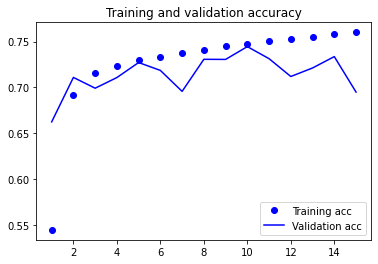

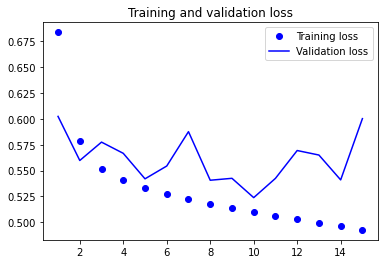

In [ ]:
plot_outputs()

# Training Final Model <a class="anchor" id="FinalModel"></a>
-----------------------------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.004)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_7 (GRU)                 (None, 32)                4032      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_final_model(model, 4)

Epoch 1/4
4094/4094 [==============================] - 2319s 566ms/step - loss: 0.4948 - acc: 0.7701
Epoch 2/4
4094/4094 [==============================] - 2293s 560ms/step - loss: 0.4683 - acc: 0.7861
Epoch 3/4
4094/4094 [==============================] - 2293s 560ms/step - loss: 0.4629 - acc: 0.7889
Epoch 4/4
4094/4094 [==============================] - 2299s 562ms/step - loss: 0.4598 - acc: 0.7909


In [ ]:
results = evaluate()

1563/1563 [==============================] - 76s 48ms/step - loss: 0.4653 - acc: 0.7908


In [ ]:
%%shell
jupyter nbconvert --to html /content/LSTMGRULayers.ipynb

[NbConvertApp] Converting notebook /content/LSTMGRULayers.ipynb to html
[NbConvertApp] Writing 621334 bytes to /content/LSTMGRULayers.html
